In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.distributions import Uniform
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, OneCycleLR
from torch_poly_lr_decay import PolynomialLRDecay

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import matplotlib.colors as colors

import wandb

PATH_DATASETS = "."
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 1024 if AVAIL_GPUS else 64
# BATCH_SIZE=1

plt.rc('font', size=30)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=30)  # 범례 폰트 크기
plt.rc('figure', titlesize=30) # figure title 폰트 크기

/home/kban/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [3]:
class ToyData(Dataset):
    def __init__(self, p_A, p_a, p_B, p_b, q_C, q_c):
        self.X = torch.column_stack([p_A, p_a, p_B, p_b])
        self.q_C = q_C
        self.q_c = q_c
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.q_C[idx], self.q_c[idx]

## Pre-processing

In [4]:
ma_test = 172
mb_test = 80

In [6]:
# process = 'toy'
# np_data = np.load('prev_0803/hh_14TeV_hh14TeV_100_array.npz')
np_data_hh = np.load('hh_13TeV_array.npz')
# # np_data = np.load('../00_data/toy_array_new.npz')
# np_data = np.load('Aux_new/'+process+'_array_preproc.npz')
# # np_data = np.load(process+'_array_preprocNboosted.npz')

In [57]:
pa_scaler = 1
pb_scaler = 1

# 1200 900 700 1000 900 700 1100 800 700
#  (1.5,2)       (0.5,2)     (1.5,1)

pa1_hh = np_data_hh['b1'][:30000]
pa2_hh = np_data_hh['b2'][:30000]
pb1_hh = np_data_hh['l2'][:30000]
pb2_hh = np_data_hh['l1'][:30000]
qc1_hh = np_data_hh['nu1'][:30000]
qc2_hh = np_data_hh['nu2'][:30000]

In [58]:
def np_mass_sq(p):
    return p[:,0]**2 - p[:,1]**2 - p[:,2]**2 - p[:,3]**2

g = np.array([1,-1,-1,-1])
def Mass(p, ax=1):
    return torch.sqrt(p[:,0]**2 - p[:,1]**2 - p[:,2]**2 - p[:,3]**2)

def npMass(p, ax=1):
    return np.sqrt(p[:,0]**2 - p[:,1]**2 - p[:,2]**2 - p[:,3]**2)

In [59]:
process = 'ttbar_2l'
# np_data = np.load('../00_data/toy_array_new.npz')
np_data = np.load('Aux_new/'+process+'_array_preproc.npz')
# np_data = np.load(process+'_array_preprocNboosted.npz')

In [60]:
pa1 = np_data['b1']
pa2 = np_data['b2']
pb1 = np_data['l2']
pb2 = np_data['l1']
qc1 = np_data['nu1']
qc2 = np_data['nu2']

In [61]:
np_momenta = [pa1, pa2, pb1, pb2, qc1, qc2]

X = np.concatenate((pa1,pa2,pb1,pb2,qc1,qc2), axis=1)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

pa1, pa2, pb1, pb2, qc1, qc2 = np.array_split(X_test[:30000], 6, axis=1)


In [62]:
pa1.shape, pb2.shape

((30000, 4), (30000, 4))

## Into PyTorch

In [63]:
np_momenta = [pa1, pa2, pb1, pb2, qc1, qc2]
np_momenta = [pa1, pa2, pb1, pb2, qc1, qc2]

X = np.concatenate((pa1, pa2, pb1, pb2, qc1, qc2), axis=1)
X_hh = np.concatenate((pa1_hh, pa2_hh, pb1_hh, pb2_hh, qc1_hh, qc2_hh), axis=1)
# X_train, X_test = train_test_split(X, test_size=0.9, random_state=42)

scaler = 100

# torch_momenta_train = list(map(lambda x: torch.tensor(x/scaler, dtype=torch.float32), np.array_split(X_train, 6, axis=1)))
torch_momenta_test  = list(map(lambda x: torch.tensor(x/scaler, dtype=torch.float32), np.array_split(X, 6, axis=1)))
torch_momenta_test_hh  = list(map(lambda x: torch.tensor(x/scaler, dtype=torch.float32), np.array_split(X_hh, 6, axis=1)))
# torch_momenta = list(map(lambda x: torch.tensor(x / 1000, dtype=torch.float32), np_momenta))

In [64]:
# ds       = ToyData(*torch_momenta_train)
ds_test  = ToyData(*torch_momenta_test)
ds_test_hh  = ToyData(*torch_momenta_test_hh)

In [65]:
npMass(pa1_hh+pa2_hh)

array([125.00000001, 124.99999999, 124.99999996, ..., 124.99999999,
       125.00000001, 124.99999999])

In [66]:
npMass(pa1+pb1+qc1)

array([172.29953679, 171.9907657 , 172.07411945, ..., 173.97423092,
       172.50049562, 173.57781597])

In [67]:
npMass(pb1+qc1)

array([80.75568464, 75.60339071, 89.13069268, ..., 82.68899817,
       79.43464837, 81.06474543])

In [68]:
# np.savetxt('test_sample_toy_new.txt', X_test[:,:16], fmt = '%5f', delimiter = ' ')

## Network

In [69]:
class ToyNet(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        
        
        hidden_layer       = hparams["hidden_layer"]
        hidden_depth       = hparams["hidden_depth"]
        learning_rate      = hparams["learning_rate"]
        batch_size         = hparams["batch_size"]
        
        self.hidden_layer  = hidden_layer
        self.hidden_depth  = hidden_depth
        self.learning_rate = learning_rate
        self.batch_size    = batch_size
        self.epochs        = hparams["epochs"]
        self.gamma        = hparams["gamma"]
        self.max_lr        = hparams['max_lr']
        self.learn_mode    = hparams['learn_mode'] # for pT mC loss on off
        self.learn_mode_sq = hparams['learn_mode_sq'] # sq or sqrt
        
        m_C = torch.tensor(hparams["m_C_init"])
        m_B = m_C + torch.tensor(hparams["m_B_add"])
        m_A = m_B + torch.tensor(hparams["m_A_add"])

        
        if self.learn_mode_sq == 'sq':
            m_C = m_C ** 2
            m_B = m_B ** 2
            m_A = m_A ** 2
        elif self.learn_mode_sq == 'sqrt':        
            m_C = m_C 
            m_B = m_B 
            m_A = m_A 
        
#         self.m_C = nn.Parameter(m_C, requires_grad=True)
        self.m_C = m_C
        self.m_B = nn.Parameter(m_B, requires_grad=True)
        self.m_A = nn.Parameter(m_A, requires_grad=True)
        
        layers = [nn.Linear(16, hidden_layer), nn.ReLU(inplace=True), nn.BatchNorm1d(hidden_layer)]
        for i in range(hidden_depth):
            layers.extend([
                nn.Linear(hidden_layer, hidden_layer),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_layer)
        ])
            

        if self.learn_mode == 'pt_mc':
            layers.append(nn.Linear(hidden_layer, 8))
        elif self.learn_mode in ['pt', 'mc']:
            layers.append(nn.Linear(hidden_layer, 6))
        elif self.learn_mode == None:
            layers.append(nn.Linear(hidden_layer, 4))
                
        self.net = nn.Sequential(*layers)
        
        self.save_hyperparameters(hparams)
        
        self.ds = None
        
    def forward(self, x):
        return self.net(x)
            
            
    def training_step(self, batch, batch_idx):
        x, _, _ = batch
        pa1 = x[:,0:4]
        pa2 = x[:,4:8]
        pb1 = x[:,8:12]
        pb2 = x[:,12:16]
        
        q = self(x)
        if self.learn_mode == 'pt_mc':
            qc1 = q[:,0:4]
            qc2 = q[:,4:8]
        elif self.learn_mode == 'pt':
            qx1 = q[:,0:1] 
            qy1 = q[:,1:2]
            qx2 = q[:,2:3] 
            qy2 = q[:,3:4]
            qz1 = q[:,4:5]   
            qz2 = q[:,5:6]          
            
            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)    
            
            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1) 
            
        elif self.learn_mode == 'mc':
            qx1 = q[:,0:1] 
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]   
            qz2 = q[:,3:4]
            Eq1 = q[:,4:5]
            Eq2 = q[:,5:6]            

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)    
            
        elif self.learn_mode == None:
            qx1 = q[:,0:1] 
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]   
            qz2 = q[:,3:4]

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)        
        
        pB1 = pb1 + qc1
        pB2 = pb2 + qc2
        pA1 = pa1 + pB1
        pA2 = pa2 + pB2
        pT = (pA1 + pA2)[:,1:3]

        if self.learn_mode_sq == 'sq':
            mC1_sq = np_mass_sq(qc1)
            mC2_sq = np_mass_sq(qc2)
            mB1_sq = np_mass_sq(pB1)
            mB2_sq = np_mass_sq(pB2)
            mA1_sq = np_mass_sq(pA1)
            mA2_sq = np_mass_sq(pA2)

        elif self.learn_mode_sq == 'sqrt':
            mC1_sq = Mass(qc1)
            mC2_sq = Mass(qc2)
            mB1_sq = Mass(pB1)
            mB2_sq = Mass(pB2)
            mA1_sq = Mass(pA1)
            mA2_sq = Mass(pA2)

        mCs = self.m_C * torch.ones_like(mC1_sq)
        mBs = self.m_B * torch.ones_like(mB1_sq)
        mAs = self.m_A * torch.ones_like(mA1_sq)
        
        

        loss_C = torch.abs(mC1_sq - mC2_sq) + torch.abs(mC1_sq - mCs) + torch.abs(mC2_sq - mCs)
        loss_B = torch.abs(mB1_sq - mB2_sq) + torch.abs(mB1_sq - mBs) + torch.abs(mB2_sq - mBs)
        loss_A = torch.abs(mA1_sq - mA2_sq) + torch.abs(mA1_sq - mAs) + torch.abs(mA2_sq - mAs)
    
        
        loss_pT = pT[:,0]**2 + pT[:,1]**2  
        

        mC_ = (mC1_sq+mC2_sq).mean()
        mB_ = (mB1_sq+mB2_sq).mean()
        mA_ = (mA1_sq+mA2_sq).mean()
        
        
        
        loss_C = loss_C #+ 1/(mC1_sq + mC2_sq + mCs) #/ mCs
        loss_B = loss_B #+ 1/(mB1_sq + mB2_sq + mBs) #/ mBs
        loss_A = loss_A #+ 1/(mA1_sq + mA2_sq + mAs) #/ mAs
        
        
        
        if self.learn_mode == 'pt_mc':
            loss = (loss_A + loss_B + loss_C).mean() + loss_pT.mean()
        elif self.learn_mode == 'pt':
            loss = (loss_A + loss_B).mean() + loss_pT.mean()
        elif self.learn_mode == 'mc':
            loss = (loss_A + loss_B + loss_C).mean() 
        elif self.learn_mode == None:        
            loss = (loss_A + loss_B).mean() 
                
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, _, _ = batch
        pa1 = x[:,0:4]
        pa2 = x[:,4:8]
        pb1 = x[:,8:12]
        pb2 = x[:,12:16]
        
        q = self(x)
        if self.learn_mode == 'pt_mc':
            qc1 = q[:,0:4]
            qc2 = q[:,4:8]
        elif self.learn_mode == 'pt':
            qx1 = q[:,0:1] 
            qy1 = q[:,1:2]
            qx2 = q[:,2:3] 
            qy2 = q[:,3:4]
            qz1 = q[:,4:5]   
            qz2 = q[:,5:6]          
            
            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)    
            
            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1) 
            
        elif self.learn_mode == 'mc':
            qx1 = q[:,0:1] 
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]   
            qz2 = q[:,3:4]
            Eq1 = q[:,4:5]
            Eq2 = q[:,5:6]            

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)    
            
        elif self.learn_mode == None:
            qx1 = q[:,0:1] 
            qy2 = q[:,1:2]
            qz1 = q[:,2:3]   
            qz2 = q[:,3:4]

            pTx = x[:,1:2]+x[:,5:6]+x[:,9:10]+x[:,13:14]
            pTy = x[:,2:3]+x[:,6:7]+x[:,10:11]+x[:,14:15]

            qx2 = -pTx-qx1
            qy1 = -pTy-qy2

            Eq1 = torch.sqrt(self.m_C**2 + qx1**2 + qy1**2 + qz1**2)
            Eq2 = torch.sqrt(self.m_C**2 + qx2**2 + qy2**2 + qz2**2)

            qc1  = torch.cat([Eq1,qx1,qy1,qz1], 1)
            qc2  = torch.cat([Eq2,qx2,qy2,qz2], 1)        
        
        pB1 = pb1 + qc1
        pB2 = pb2 + qc2
        pA1 = pa1 + pB1
        pA2 = pa2 + pB2
        pT = (pA1 + pA2)[:,1:3]

        if self.learn_mode_sq == 'sq':
            mC1_sq = np_mass_sq(qc1)
            mC2_sq = np_mass_sq(qc2)
            mB1_sq = np_mass_sq(pB1)
            mB2_sq = np_mass_sq(pB2)
            mA1_sq = np_mass_sq(pA1)
            mA2_sq = np_mass_sq(pA2)

        elif self.learn_mode_sq == 'sqrt':
            mC1_sq = Mass(qc1)
            mC2_sq = Mass(qc2)
            mB1_sq = Mass(pB1)
            mB2_sq = Mass(pB2)
            mA1_sq = Mass(pA1)
            mA2_sq = Mass(pA2)

        mCs = self.m_C * torch.ones_like(mC1_sq)
        mBs = self.m_B * torch.ones_like(mB1_sq)
        mAs = self.m_A * torch.ones_like(mA1_sq)
        
        
        loss_C = torch.abs(mC1_sq - mC2_sq) + torch.abs(mC1_sq - mCs) + torch.abs(mC2_sq - mCs)
        loss_B = torch.abs(mB1_sq - mB2_sq) + torch.abs(mB1_sq - mBs) + torch.abs(mB2_sq - mBs)
        loss_A = torch.abs(mA1_sq - mA2_sq) + torch.abs(mA1_sq - mAs) + torch.abs(mA2_sq - mAs)
        
        loss_pT = pT[:,0]**2 + pT[:,1]**2  
        
        mC_ = (mC1_sq+mC2_sq).mean()
        mB_ = (mB1_sq+mB2_sq).mean()
        mA_ = (mA1_sq+mA2_sq).mean()
        
        
        loss_C = loss_C #+ 1/(mC1_sq + mC2_sq + mCs) #/ mCs
        loss_B = loss_B #+ 1/(mB1_sq + mB2_sq + mBs) #/ mBs
        loss_A = loss_A #+ 1/(mA1_sq + mA2_sq + mAs) #/ mAs
        
        
        if self.learn_mode == 'pt_mc':
            loss = (loss_A + loss_B + loss_C).mean() + loss_pT.mean()
        elif self.learn_mode == 'pt':
            loss = (loss_A + loss_B).mean() + loss_pT.mean()
        elif self.learn_mode == 'mc':
            loss = (loss_A + loss_B + loss_C).mean() 
        elif self.learn_mode == None:        
            loss = (loss_A + loss_B).mean() 
        
        
        self.log('val_loss', loss)
        self.log('loss_A', loss_A)
        self.log('loss_B', loss_B)
        self.log('loss_C', loss_C)
        self.log('loss_pT', loss_pT)
        self.log('m_A', self.m_A)
        self.log('m_B', self.m_B)
        self.log('m_C', self.m_C)
        self.log('m_A1', mA1_sq)
        self.log('m_A2', mA2_sq)
        self.log('m_B1', mB1_sq)
        self.log('m_B2', mB2_sq)
        self.log('m_C1', mC1_sq)
        self.log('m_C2', mC2_sq)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
            betas=(0.99, 0.9999),
            weight_decay=0.1
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": OneCycleLR(
                    optimizer, 
                    max_lr=self.max_lr,
                    steps_per_epoch=len(self.ds_train) // self.batch_size + 1,
                    epochs = self.epochs,
                ),
                "interval": "step",
                "monitor": "val_loss",
                "strict": True,
            }
        } 

        
    def prepare_data(self):
#         self.ds = ToyData(*torch_momenta)
        self.ds = ToyData(*torch_momenta_train)
        self.N = len(self.ds)
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [N_train, N_val])
    
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [70]:
mc = 0/scaler

hparams = {
    "hidden_layer": 256,
    "hidden_depth": 5,
    "learning_rate": 1e-4,
    "batch_size": BATCH_SIZE,
    "m_C_init": mc,
    "m_B_add": 0.3,
    "m_A_add": 0.3,
    "max_lr": 1e-4,
    "epochs": 50,
    "gamma": 0.9,
    "learn_mode": None, # 'pt_mc', 'mc', 'pt', None
    "learn_mode_sq":'sqrt', # 'sq' , 'sqrt' // Note: For 'sqrt', ONLY 'pt' and None are available for the physical reason.
}

## Test

In [71]:
# model = ToyNet.load_from_checkpoint('Aux_new/noreg_toy/Auxiliary_noreg_toy.pth')
model = ToyNet.load_from_checkpoint('Aux_new/noreg_ttbar/Auxiliary_noreg_ttbar.pth')
# model = ToyNet.load_from_checkpoint('Aux_new/reg_mA_toy/Auxiliary_regmA.pth')

In [72]:
hparams = model.hparams

In [130]:
scaler_N = scaler

# ma_min = 0.7*1000
# ma_max = 1.3*1000
# mb_min = 0.6*1000
# mb_max = 1.0*1000

ma_min = 0*scaler_N
ma_max = 5*scaler_N
mb_min = 0.*scaler_N
mb_max = 3*scaler_N

In [131]:
model.eval()
dl_total = DataLoader(ds_test, batch_size=BATCH_SIZE)
dl_total_hh = DataLoader(ds_test_hh, batch_size=BATCH_SIZE)

In [132]:
def decoder(model, dl):
    dl_iter = iter(dl)
    x_init, _, _ = next(dl_iter)
    output = model(x_init)
    for data in dl_iter:
        x, _, _ = data
        output = torch.concat([output, model(x)])
    return output

In [133]:
output = decoder(model, dl_total)[:30000]
output_hh = decoder(model, dl_total_hh)[:30000]

In [134]:
len(output), len(output_hh)

(30000, 30000)

In [135]:
mc = 0/scaler

In [136]:
qx1 = output[:,0:1].detach().numpy()
qy2 = output[:,1:2].detach().numpy()
qz1 = output[:,2:3].detach().numpy()
qz2 = output[:,3:4].detach().numpy()

pTx = (pa1[:,1:2]+pa2[:,1:2]+pb1[:,1:2]+pb2[:,1:2])/scaler_N
pTy = (pa1[:,2:3]+pa2[:,2:3]+pb1[:,2:3]+pb2[:,2:3])/scaler_N

qx2 = -pTx-qx1
qy1 = -pTy-qy2

Eq1 = np.sqrt(mc**2 + qx1**2 + qy1**2 + qz1**2)
Eq2 = np.sqrt(mc**2 + qx2**2 + qy2**2 + qz2**2)

In [137]:
qx1_hh = output_hh[:,0:1].detach().numpy()
qy2_hh = output_hh[:,1:2].detach().numpy()
qz1_hh = output_hh[:,2:3].detach().numpy()
qz2_hh = output_hh[:,3:4].detach().numpy()

pTx_hh = (pa1_hh[:,1:2]+pa2_hh[:,1:2]+pb1_hh[:,1:2]+pb2_hh[:,1:2])/scaler_N
pTy_hh = (pa1_hh[:,2:3]+pa2_hh[:,2:3]+pb1_hh[:,2:3]+pb2_hh[:,2:3])/scaler_N

qx2_hh = -pTx_hh-qx1_hh
qy1_hh = -pTy_hh-qy2_hh

Eq1_hh = np.sqrt(mc**2 + qx1_hh**2 + qy1_hh**2 + qz1_hh**2)
Eq2_hh = np.sqrt(mc**2 + qx2_hh**2 + qy2_hh**2 + qz2_hh**2)

In [138]:
# np.savez(process+'_array_preproc_test.npz',b1=pa1, b2=pa2, l1=pb2, l2=pb1, nu1=qc1,nu2=qc2)  ## preprocessed test data save

In [139]:
qc1_out  = np.concatenate([Eq1,qx1,qy1,qz1], 1)
qc2_out  = np.concatenate([Eq2,qx2,qy2,qz2], 1)    

qc1_out_hh  = np.concatenate([Eq1_hh,qx1_hh,qy1_hh,qz1_hh], 1)
qc2_out_hh  = np.concatenate([Eq2_hh,qx2_hh,qy2_hh,qz2_hh], 1)    

In [140]:
pB1_out = pb1 /scaler_N + qc1_out
pB2_out = pb2 /scaler_N + qc2_out
pA1_out = pa1 /scaler_N + pB1_out
pA2_out = pa2 /scaler_N + pB2_out

mC1_out = npMass(qc1_out)
mC2_out = npMass(qc2_out)
mB1_out = npMass(pB1_out)
mB2_out = npMass(pB2_out)
mA1_out = npMass(pA1_out)
mA2_out = npMass(pA2_out)
    
# if hparams['learn_mode_sq'] == 'sq':
#     m_A_sq = np.sqrt(model.m_A.item())
#     m_B_sq = np.sqrt(model.m_B.item())
# elif hparams['learn_mode_sq'] == 'sqrt':
#     m_A_sq = model.m_A.item()
#     m_B_sq = model.m_B.item()

ma1 = mA1_out
ma2 = mA2_out
mb1 = mB1_out
mb2 = mB2_out


q1 = qc1_out
q2 = qc2_out

/home/kban/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [141]:
pB1_out_hh = pb1_hh /scaler_N + qc1_out_hh
pB2_out_hh = pb2_hh /scaler_N + qc2_out_hh
pA1_out_hh = pa1_hh /scaler_N + pB1_out_hh
pA2_out_hh = pa2_hh /scaler_N + pB2_out_hh

mC1_out_hh = npMass(qc1_out_hh)
mC2_out_hh = npMass(qc2_out_hh)
mB1_out_hh = npMass(pB1_out_hh)
mB2_out_hh = npMass(pB2_out_hh)
mA1_out_hh = npMass(pA1_out_hh)
mA2_out_hh = npMass(pA2_out_hh)
    
# if hparams['learn_mode_sq'] == 'sq':
#     m_A_sq = np.sqrt(model.m_A.item())
#     m_B_sq = np.sqrt(model.m_B.item())
# elif hparams['learn_mode_sq'] == 'sqrt':
#     m_A_sq = model.m_A.item()
#     m_B_sq = model.m_B.item()

ma1_hh = mA1_out_hh
ma2_hh = mA2_out_hh
mb1_hh = mB1_out_hh
mb2_hh = mB2_out_hh


q1_hh = qc1_out_hh
q2_hh = qc2_out_hh

/home/kban/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [142]:
ma1, mb1

(array([1.70069825, 1.67884208, 1.73454876, ..., 1.75369864, 1.6883809 ,
        1.73907622]),
 array([0.03749811, 0.76740811, 0.70707057, ..., 0.80468044, 0.91233789,
        0.72419693]))

In [143]:
# path_folder='noreg_toy' #reg_mAB_toy
# mCC = 700

/home/kban/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


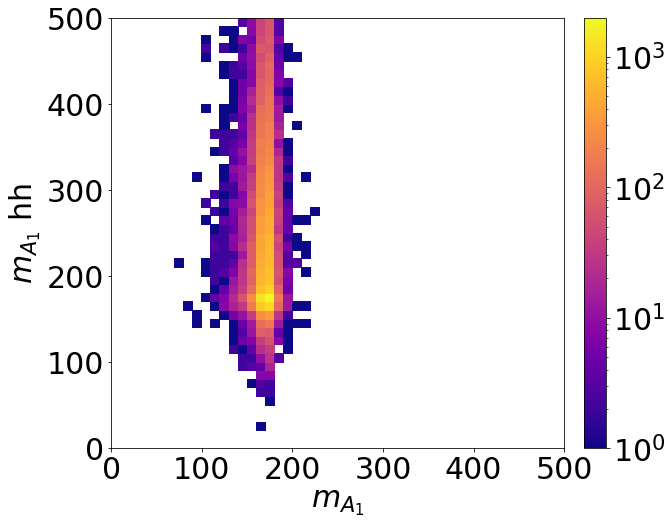

In [144]:
N_bins = 50

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))

currentAxis = plt.gca()

im = ax1.hist2d(ma1[:50000]*scaler_N, ma1_hh[:50000]*scaler_N, bins=N_bins, normed=False, cmap='plasma',norm=colors.LogNorm(),  range=([ma_min,ma_max],[ma_min,ma_max])) #norm=colors.LogNorm(), 

# plt.hlines(ma_test,0,50000,color="red")
# plt.vlines(mb_test,0,50000,color="red")


ax1.set_xlabel(r'$m_{A_1}$')
ax1.set_ylabel(r'$m_{A_1}$ hh')

plt.colorbar(im[3],fraction=0.05, pad=0.04)

plt.tight_layout()
# plt.savefig(path_folder +'/heatmap_toy_ma1_mb1_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

/home/kban/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


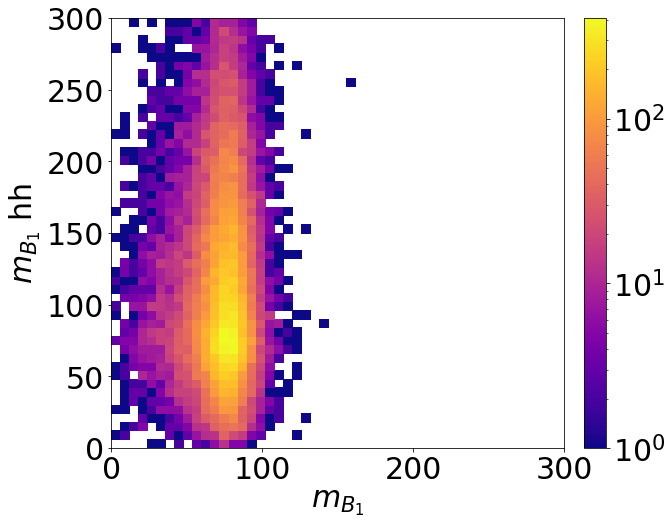

In [145]:
N_bins = 50

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))

currentAxis = plt.gca()

im = ax1.hist2d(mb1[:50000]*scaler_N, mb1_hh[:50000]*scaler_N, bins=N_bins, normed=False, cmap='plasma',norm=colors.LogNorm(),  range=([mb_min,mb_max],[mb_min,mb_max])) #norm=colors.LogNorm(), 

# plt.hlines(ma_test,0,50000,color="red")
# plt.vlines(mb_test,0,50000,color="red")


ax1.set_xlabel(r'$m_{B_1}$')
ax1.set_ylabel(r'$m_{B_1}$ hh')

plt.colorbar(im[3],fraction=0.05, pad=0.04)

plt.tight_layout()
# plt.savefig(path_folder +'/heatmap_toy_ma1_mb1_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

/home/kban/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


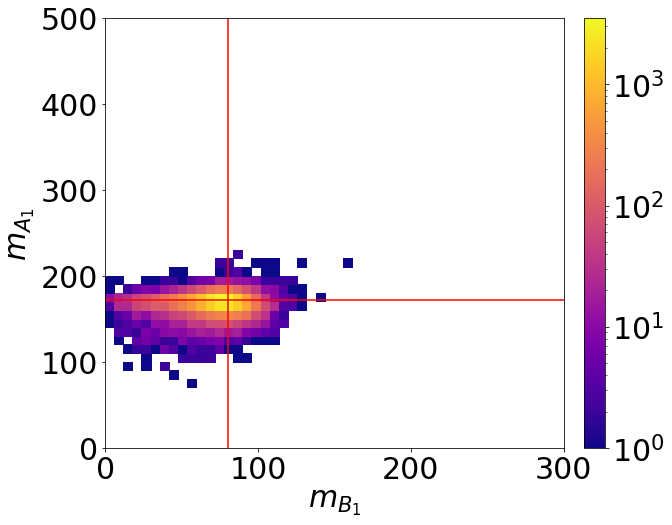

In [146]:
N_bins = 50

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))

currentAxis = plt.gca()

im = ax1.hist2d(mb1[:50000]*scaler_N, ma1[:50000]*scaler_N, bins=N_bins, normed=False, cmap='plasma',norm=colors.LogNorm(),  range=([mb_min,mb_max],[ma_min,ma_max])) #norm=colors.LogNorm(), 

plt.hlines(ma_test,0,50000,color="red")
plt.vlines(mb_test,0,50000,color="red")


ax1.set_xlabel(r'$m_{B_1}$')
ax1.set_ylabel(r'$m_{A_1}$')

plt.colorbar(im[3],fraction=0.05, pad=0.04)

plt.tight_layout()
# plt.savefig(path_folder +'/heatmap_toy_ma1_mb1_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

/home/kban/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


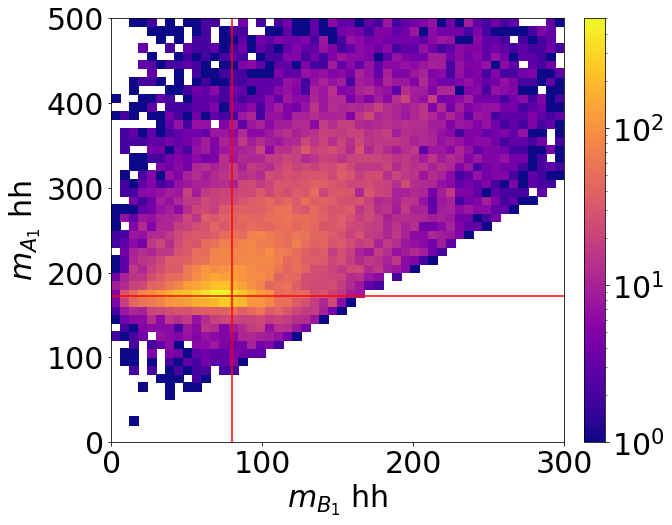

In [147]:
N_bins = 50

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))

currentAxis = plt.gca()

im = ax1.hist2d(mb1_hh[:50000]*scaler_N, ma1_hh[:50000]*scaler_N, bins=N_bins, normed=False, cmap='plasma',norm=colors.LogNorm(),  range=([mb_min,mb_max],[ma_min,ma_max])) #norm=colors.LogNorm(), 

plt.hlines(ma_test,0,50000,color="red")
plt.vlines(mb_test,0,50000,color="red")


ax1.set_xlabel(r'$m_{B_1}$ hh')
ax1.set_ylabel(r'$m_{A_1}$ hh')

plt.colorbar(im[3],fraction=0.05, pad=0.04)

plt.tight_layout()
# plt.savefig(path_folder +'/heatmap_toy_ma1_mb1_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

/home/kban/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  import sys


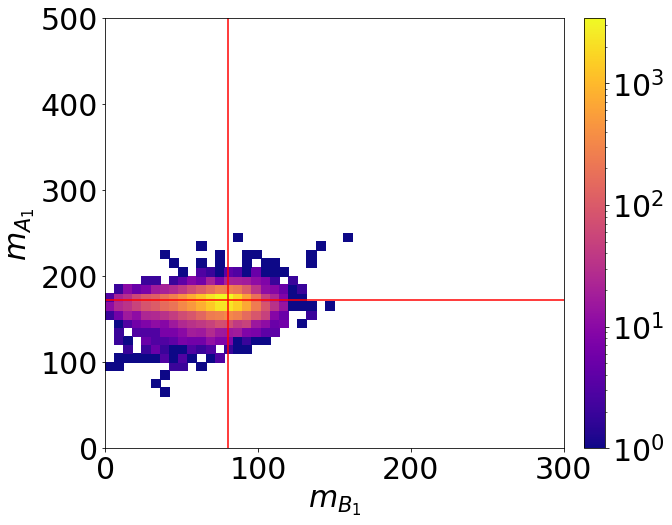

In [148]:
N_bins = 50

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))

currentAxis = plt.gca()

im = ax1.hist2d(mb2[:50000]*scaler_N, ma2[:50000]*scaler_N, bins=N_bins, normed=False, cmap='plasma',norm=colors.LogNorm(),  range=([mb_min,mb_max],[ma_min,ma_max])) #norm=colors.LogNorm(), 

plt.hlines(ma_test,0,50000,color="red")
plt.vlines(mb_test,0,50000,color="red")


ax1.set_xlabel(r'$m_{B_1}$')
ax1.set_ylabel(r'$m_{A_1}$')

plt.colorbar(im[3],fraction=0.05, pad=0.04)

plt.tight_layout()
# plt.savefig(path_folder +'/heatmap_toy_ma1_mb1_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

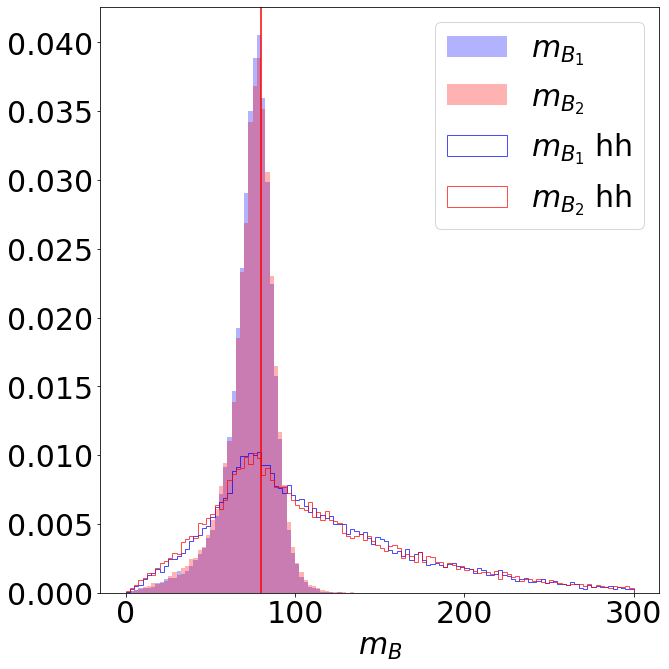

In [151]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 10))

N_bins = 120

ax = ax1.hist(mb1[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.3, label=r'$m_{B_1}$', color='b', range=[mb_min,mb_max], histtype='stepfilled')
ax = ax1.hist(mb2[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.3, label=r'$m_{B_2}$', color='r', range=[mb_min,mb_max], histtype='stepfilled')


ax = ax1.hist(mb1_hh[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.7, label=r'$m_{B_1}$ hh', color='b', range=[mb_min,mb_max], histtype='step')
ax = ax1.hist(mb2_hh[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.7, label=r'$m_{B_2}$ hh', color='r', range=[mb_min,mb_max], histtype='step')
ax1.axvline(mb_test, color="red")

# plt.ylim(0,0.08)
plt.legend()
ax1.set_xlabel(r'$m_B$')
plt.tight_layout()

# plt.savefig(path_folder +'/hist_toy_mb12_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

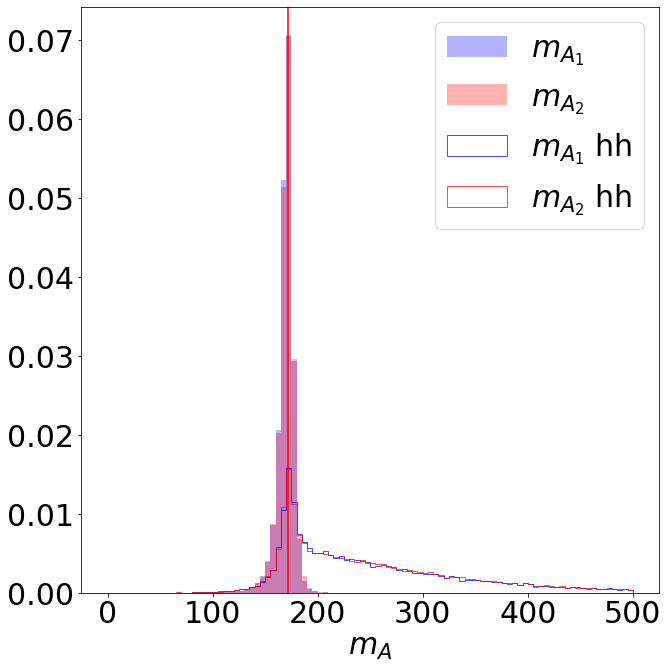

In [153]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 10))

N_bins = 100

ax = ax1.hist(ma1[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.3, label=r'$m_{A_1}$', color='b', range=[ma_min,ma_max], histtype='stepfilled')
ax = ax1.hist(ma2[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.3, label=r'$m_{A_2}$', color='r', range=[ma_min,ma_max], histtype='stepfilled')

ax = ax1.hist(ma1_hh[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.7, label=r'$m_{A_1}$ hh', color='b', range=[ma_min,ma_max], histtype='step')
ax = ax1.hist(ma2_hh[:50000]*scaler_N, bins=N_bins, density=True, alpha=0.7, label=r'$m_{A_2}$ hh', color='r', range=[ma_min,ma_max], histtype='step')
ax1.axvline(ma_test, color="red")

# plt.ylim(0,0.07)
plt.legend()
ax1.set_xlabel(r'$m_A$')
plt.tight_layout()

# plt.savefig(path_folder +'/hist_toy_ma12_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

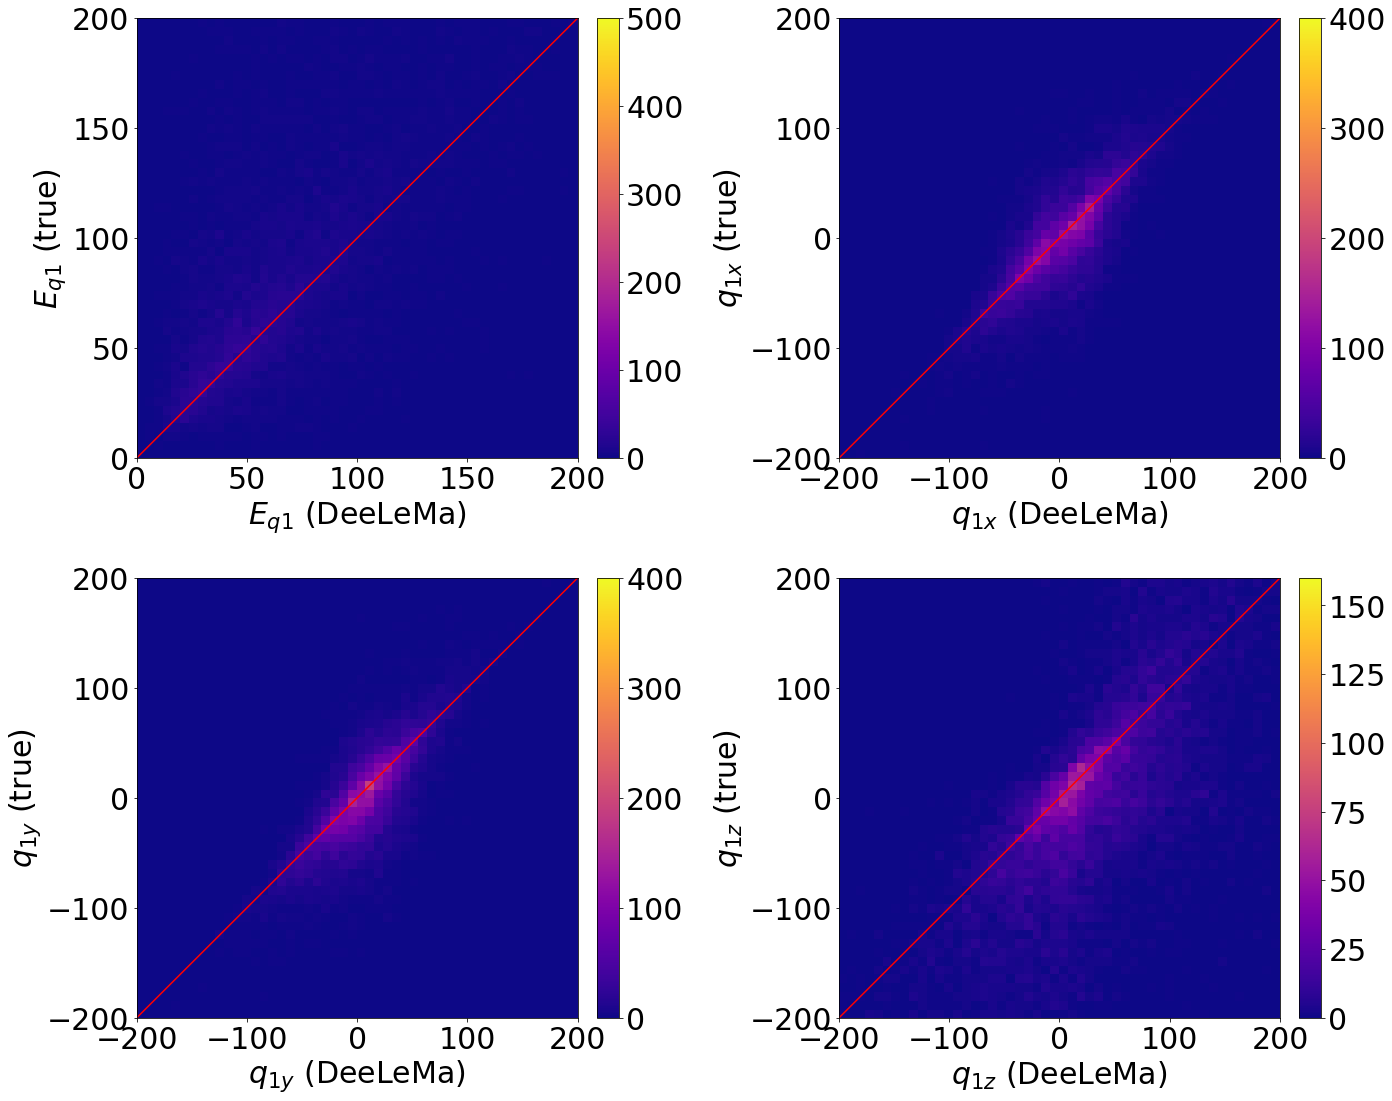

In [155]:
from scipy.stats import binned_statistic_2d
from pylab import figure, cm
from matplotlib.colors import LogNorm
from matplotlib import colors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

N_bins = 50

fig1 = plt.figure(figsize=(20, 16))
ax1 = fig1.add_subplot(221)


currentAxis = plt.gca()

im1 = ax1.hist2d(q1[:10000,0]*scaler_N,qc1[:10000,0], bins=N_bins, density=False, cmap='plasma', range=([0,200],[0,200]), vmin=0, vmax=500)
fig1.colorbar(im1[3],fraction=0.05, pad=0.04)
plt.plot([0,5000],[0,5000], color='red')

ax2 = fig1.add_subplot(222)
im2 = ax2.hist2d(q1[:10000,1]*scaler_N,qc1[:10000,1], bins=N_bins, density=False, cmap='plasma', range=([-200,200],[-200,200]), vmin=0, vmax=400)
fig1.colorbar(im2[3],fraction=0.05, pad=0.04)
plt.plot([-5000,5000],[-5000,5000], color='red')

ax3 = fig1.add_subplot(223)
im3 = ax3.hist2d(q1[:10000,2]*scaler_N,qc1[:10000,2], bins=N_bins, density=False, cmap='plasma', range=([-200,200],[-200,200]), vmin=0, vmax=400)
fig1.colorbar(im3[3],fraction=0.05, pad=0.04)
plt.plot([-5000,5000],[-5000,5000], color='red')

ax4 = fig1.add_subplot(224)
im4 = ax4.hist2d(q1[:10000,3]*scaler_N,qc1[:10000,3], bins=N_bins, density=False, cmap='plasma', range=([-200,200],[-200,200]), vmin=0, vmax=160)
fig1.colorbar(im4[3],fraction=0.05, pad=0.04)
plt.plot([-5000,5000],[-5000,5000], color='red')



ax1.set_xlabel(r'$E_{q1}\ $(DeeLeMa)')
ax1.set_ylabel(r'$E_{q1}$ (true)')

ax2.set_xlabel(r'$q_{1x}\ $(DeeLeMa)')
ax2.set_ylabel(r'$q_{1x}$ (true)')

ax3.set_xlabel(r'$q_{1y}\ $(DeeLeMa)')
ax3.set_ylabel(r'$q_{1y}$ (true)')

ax4.set_xlabel(r'$q_{1z}\ $(DeeLeMa)')
ax4.set_ylabel(r'$q_{1z}$ (true)')


plt.tight_layout()

# plt.savefig(path_folder +'/heatmap_toy_Eqxyz1_50k_mC'+str(mCC)+'.pdf',dpi=200, bbox_inces='tight')

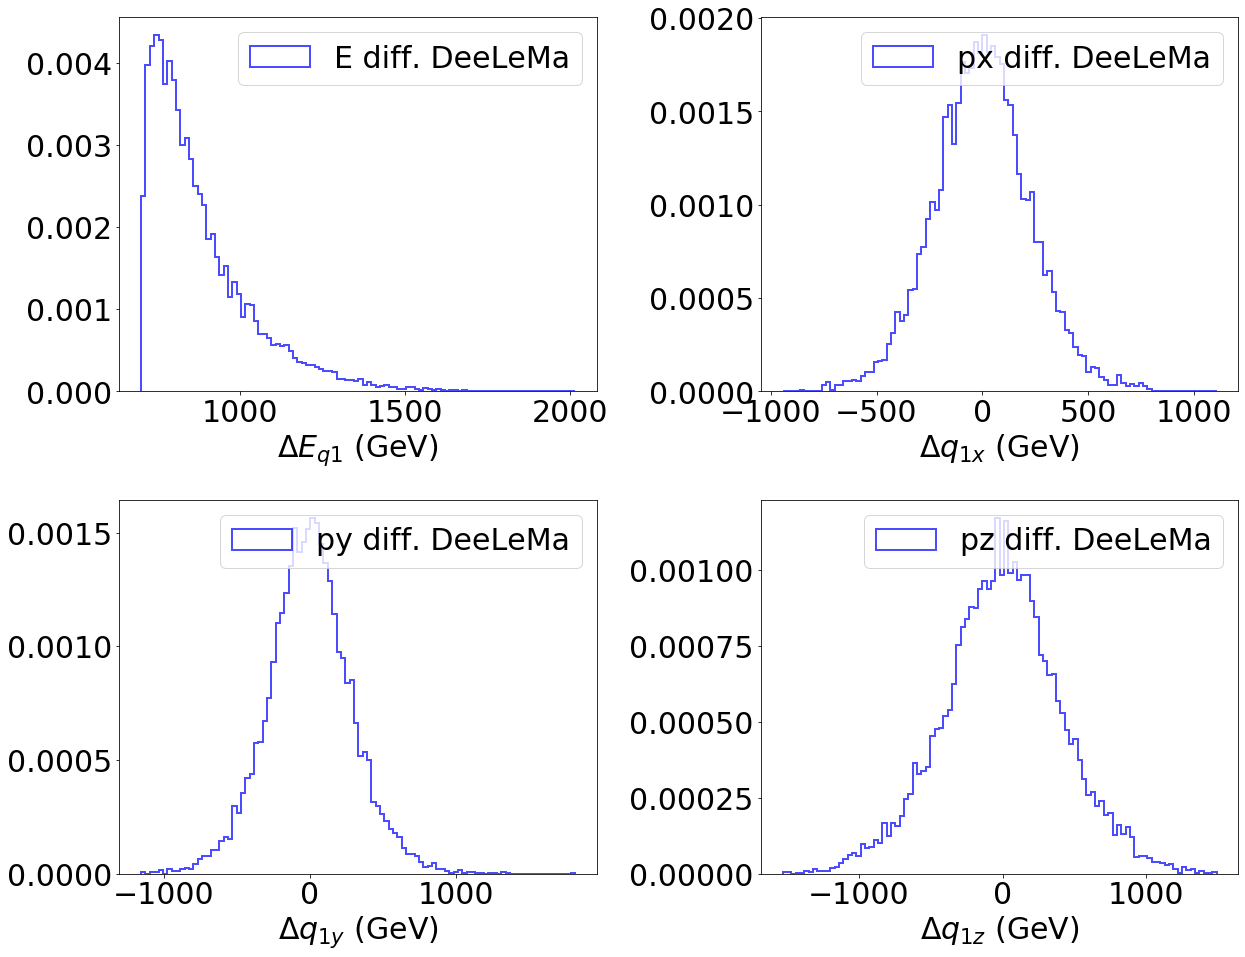

In [751]:
import matplotlib.pyplot as plt
import matplotlib


fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(18, 14))

N_bins = 100
histtype='step'
lw = 2
alp = 0.7
p_max = 1000



ax = ax1.hist(q1[:10000,0]*scaler_N, bins=N_bins, density=True, alpha=alp, label='E diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax1.set_yscale('log')
ax1.legend()
ax1.set_xlabel(r'$\Delta E_{q1}$ (GeV)')


ax = ax2.hist(q1[:10000,1]*scaler_N, bins=N_bins, density=True, alpha=alp, label='px diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel(r'$\Delta q_{1x}$ (GeV)')


ax = ax3.hist(q1[:10000,2]*scaler_N, bins=N_bins, density=True, alpha=alp, label='py diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax3.set_yscale('log')
ax3.legend()
ax3.set_xlabel(r'$\Delta q_{1y}$ (GeV)')



ax = ax4.hist(q1[:10000,3]*scaler_N, bins=N_bins, density=True, alpha=alp, label='pz diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax4.set_yscale('log')
# plt.ylim(0,7)
ax4.legend()
ax4.set_xlabel(r'$\Delta q_{1z}$ (GeV)')
plt.tight_layout()



In [ ]:
import matplotlib.pyplot as plt
import matplotlib


fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(18, 14))

N_bins = 100
histtype='step'
lw = 2
alp = 0.7
p_max = 1000



ax = ax1.hist(qc1[:10000,0], bins=N_bins, density=True, alpha=alp, label='E diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax1.set_yscale('log')
ax1.legend()
ax1.set_xlabel(r'$\Delta E_{q1}$ (GeV)')


ax = ax2.hist(qc1[:10000,1], bins=N_bins, density=True, alpha=alp, label='px diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel(r'$\Delta q_{1x}$ (GeV)')


ax = ax3.hist(qc1[:10000,2], bins=N_bins, density=True, alpha=alp, label='py diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax3.set_yscale('log')
ax3.legend()
ax3.set_xlabel(r'$\Delta q_{1y}$ (GeV)')



ax = ax4.hist(qc1[:10000,3], bins=N_bins, density=True, alpha=alp, label='pz diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax4.set_yscale('log')
# plt.ylim(0,7)
ax4.legend()
ax4.set_xlabel(r'$\Delta q_{1z}$ (GeV)')
plt.tight_layout()



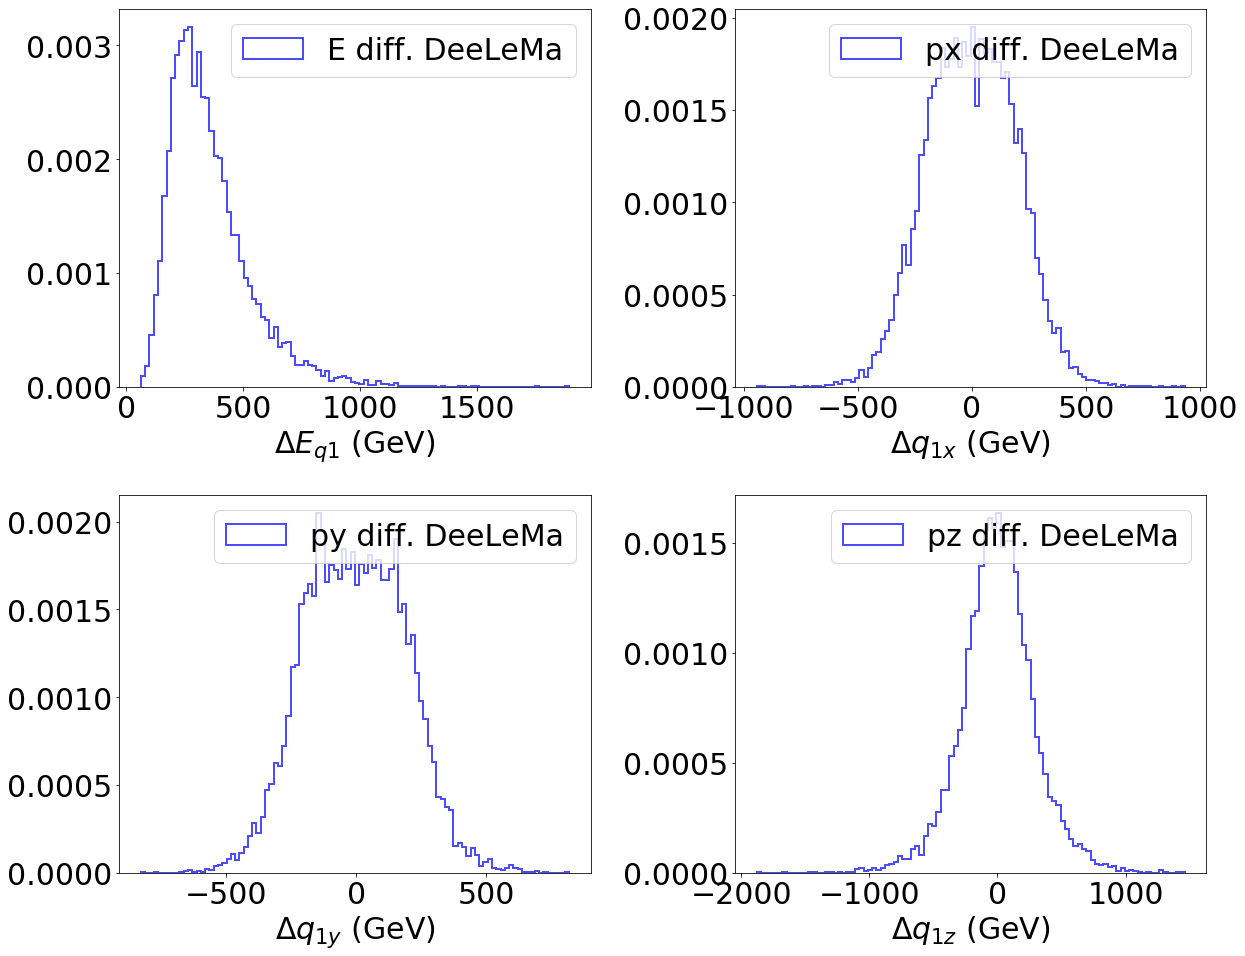

In [162]:
import matplotlib.pyplot as plt
import matplotlib


fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(18, 14))

N_bins = 100
histtype='step'
lw = 2
alp = 0.7
p_max = 1000



ax = ax1.hist(pa1[:10000,0], bins=N_bins, density=True, alpha=alp, label='E diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax1.set_yscale('log')
ax1.legend()
ax1.set_xlabel(r'$\Delta E_{q1}$ (GeV)')


ax = ax2.hist(pa1[:10000,1], bins=N_bins, density=True, alpha=alp, label='px diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel(r'$\Delta q_{1x}$ (GeV)')


ax = ax3.hist(pa1[:10000,2], bins=N_bins, density=True, alpha=alp, label='py diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax3.set_yscale('log')
ax3.legend()
ax3.set_xlabel(r'$\Delta q_{1y}$ (GeV)')



ax = ax4.hist(pa1[:10000,3], bins=N_bins, density=True, alpha=alp, label='pz diff. DeeLeMa', color='b', histtype=histtype, linewidth=lw) #, range=[0.5,0.75])
# ax4.set_yscale('log')
# plt.ylim(0,7)
ax4.legend()
ax4.set_xlabel(r'$\Delta q_{1z}$ (GeV)')
plt.tight_layout()



In [227]:
pa1[:,0].mean(), pa1[:,1].mean(), pa1[:,3].mean()

(360.0310663180481, -0.9743330702891548, 2.7842801887291557)

In [225]:
pa2[:,0].mean(), pa2[:,1].mean(), pa2[:,3].mean()

(354.68099474359246, 1.7137642534398398, -3.4577239747051536)

In [222]:
pb1[:,0].mean(), pb1[:,1].mean(), pb1[:,3].mean()

(237.5756427621059, 2.1554898808242964, 1.8319107727639268)

In [196]:
360/257


1.4007782101167314

In [224]:
237/131

1.8091603053435115

In [228]:
pa1[:,0].std(), pa1[:,1].std(), pa1[:,3].std()

(174.93267968485281, 193.71193175913905, 291.8434779931734)

In [229]:
174/134

1.2985074626865671

In [230]:
193/135

1.4296296296296296

In [231]:
291/217

1.3410138248847927